# Library and pip install

In [1]:
!pip install datasets
!pip install matplotlib transformers segmentation-models-pytorch torch torchvision
!pip install wandb

# Import libraries
import wandb
wandb.login()

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import Grayscale
import numpy as np
import segmentation_models_pytorch as smp
from transformers import AutoConfig, AutoModelForImageSegmentation
import torch.nn.functional as F
from sklearn.decomposition import PCA

wandb: Currently logged in as: yusuke-sugihara. Use `wandb login --relogin` to force relogin


# Load the dataset

In [2]:
# subset_size_train = 1000
# Load the dataset
dataset_full_train = load_dataset('benschill/brain-tumor-collection', split='train')
dataset_full_test = load_dataset('benschill/brain-tumor-collection', split='test')

dataset_train = dataset_full_train
# dataset_train = dataset_full_train.select(range(subset_size_train))
dataset_test = dataset_full_test

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for benschill/brain-tumor-collection contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/benschill/brain-tumor-collection
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major

In [3]:
# Checking the dimensions of the first image in the training dataset
first_image = dataset_train[0]['image']
image_dimensions = first_image.size  # PIL images use size attribute for dimensions

print("Image Dimensions:", image_dimensions)

Image Dimensions: (512, 512)


In [4]:
def add_gaussian_noise(image):
    noise = torch.randn(image.size()) * 0.3  # Adjust the noise level to your preference
    noisy_image = image + noise
    return torch.clamp(noisy_image, 0., 1.)  # Ensure the pixel values are still between 0 and 1

In [5]:
def get_dataloader(dataset, batch_size=32, add_noise=True):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        Grayscale(num_output_channels=1),
        transforms.ToTensor()
    ])

    if add_noise:
        dataset = [(add_gaussian_noise(transform(img['image'])), transform(img['image'])) for img in dataset]
    else:
        dataset = [(transform(img['image']), img['label']) for img in dataset]

    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
def visualize_reconstruction(model, dataloader, device, model_name="Model", num_images=5, include_noisy=True):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need to track gradients for visualization
        for i, (noisy_img, original_img) in enumerate(dataloader):
            if i == 1:  # Just use one batch for visualization
                original_img, noisy_img = original_img.to(device), noisy_img.to(device)
                recon_img = model(noisy_img)  # Get the reconstructed images
                original_img, noisy_img, recon_img = original_img.cpu(), noisy_img.cpu(), recon_img.cpu()  # Move images back to CPU for visualization

                # Plot original, noisy, and reconstructed images
                fig, axes = plt.subplots(3, num_images, figsize=(8,8))
                for j in range(num_images):
                    # Display original
                    axes[0, j].imshow(original_img[j].squeeze(), cmap='gray')
                    axes[0, j].set_title('Original')
                    axes[0, j].axis('off')

                    # Display noisy
                    axes[1, j].imshow(noisy_img[j].squeeze(), cmap='gray')
                    axes[1, j].set_title('Noisy')
                    axes[1, j].axis('off')

                    # Display reconstruction
                    axes[2, j].imshow(recon_img[j].squeeze(), cmap='gray')
                    axes[2, j].set_title('Reconstructed')
                    axes[2, j].axis('off')

                fig.suptitle(f'{model_name}')  # Adding a title with the model name
                plt.tight_layout()
                plt.show()
                break

In [7]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        self.enc_conv1 = nn.Conv2d(1, 32, 3, stride=2, padding=1) #64
        self.enc_bn1 = nn.BatchNorm2d(32)
        self.enc_conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1) #32
        self.enc_bn2 = nn.BatchNorm2d(64)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1) #16
        self.enc_bn3 = nn.BatchNorm2d(128)
        self.enc_conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1) #8
        self.enc_bn4 = nn.BatchNorm2d(256)
        self.enc_conv5 = nn.Conv2d(256, 512, 3, stride=2, padding=1) #4
        self.enc_bn5 = nn.BatchNorm2d(512)

        # Calculate the flatten size
        self.flatten_size = 512 * (128 // 32) * (128 // 32)
        self.fc1 = nn.Linear(self.flatten_size, self.latent_dim)

        # Decoder layers
        self.fc2 = nn.Linear(self.latent_dim, self.flatten_size)
        self.dec_conv1 = nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(256)
        self.dec_conv2 = nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(128)
        self.dec_conv3 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(64)
        self.dec_conv4 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.dec_bn4 = nn.BatchNorm2d(32)
        self.dec_conv5 = nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)

    def forward(self, x):
        # Encoder forward
        e1 = F.leaky_relu(self.enc_bn1(self.enc_conv1(x)), 0.01)
        e2 = F.leaky_relu(self.enc_bn2(self.enc_conv2(e1)), 0.01)
        e3 = F.leaky_relu(self.enc_bn3(self.enc_conv3(e2)), 0.01)
        e4 = F.leaky_relu(self.enc_bn4(self.enc_conv4(e3)), 0.01)
        e5 = F.leaky_relu(self.enc_bn5(self.enc_conv5(e4)), 0.01)

        z = self.fc1(e5.view(-1, self.flatten_size))

        # Decoder forward
        z = self.fc2(z)
        z = z.view(-1, 512, 128 // 32, 128 // 32)
        d1 = F.leaky_relu(self.dec_bn1(self.dec_conv1(z)), 0.01)
        d2 = F.leaky_relu(self.dec_bn2(self.dec_conv2(d1)), 0.01)
        d3 = F.leaky_relu(self.dec_bn3(self.dec_conv3(d2)), 0.01)
        d4 = F.leaky_relu(self.dec_bn4(self.dec_conv4(d3)), 0.01)
        d5 = torch.sigmoid(self.dec_conv5(d4))

        return d5

In [8]:
# Set up W&B configuration (not used directly in sweeps but good for reference)
config_dict = {
    "learning_rate": 5e-4,
    "epochs": 40,
    "batch_size": 16,
    "latent_dim": 512,
    "momentum": 0.9,
    "model_name": "Denoising_AE"
}


In [9]:
def train_AE():
    with wandb.init(config=config_dict) as run:  # Use the predefined config_dict
        config = run.config

        # Set up model, optimizer, and data loader
        model = Autoencoder(latent_dim=config.latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        train_loader = get_dataloader(dataset_train, batch_size=config.batch_size, add_noise=True)
        test_loader = get_dataloader(dataset_test, batch_size=config.batch_size)

        # Training loop
        model.train()
        for epoch in range(config.epochs):
            total_loss = 0
            for noisy_img, clean_img in train_loader:
                noisy_img, clean_img = noisy_img.to(device), clean_img.to(device)
                optimizer.zero_grad()
                recon_batch = model(noisy_img)
                loss = nn.functional.mse_loss(recon_batch, clean_img)  # Compare with clean image
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            average_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}, Average Loss: {average_loss}")

            # Log the loss to WandB
            wandb.log({"epoch": epoch+1, "Average_loss": average_loss})

        # Optional: Visualize some reconstructed images after training
        visualize_reconstruction(model, test_loader, device, "Autoencoder", include_noisy=True)


Using device: cuda


Epoch 1, Average Loss: 0.027024845380543006
Epoch 2, Average Loss: 0.014030128039626612
Epoch 3, Average Loss: 0.01193352825422254
Epoch 4, Average Loss: 0.010702437868652244
Epoch 5, Average Loss: 0.009806856657895777
Epoch 6, Average Loss: 0.009115670634330147
Epoch 7, Average Loss: 0.008589184110880726
Epoch 8, Average Loss: 0.007986094696550733
Epoch 9, Average Loss: 0.0079327102465969
Epoch 10, Average Loss: 0.007428626216844552
Epoch 11, Average Loss: 0.00729986605907066
Epoch 12, Average Loss: 0.0070239708060398694
Epoch 13, Average Loss: 0.00671972587135517
Epoch 14, Average Loss: 0.006808611478966971
Epoch 15, Average Loss: 0.0062801948334607815
Epoch 16, Average Loss: 0.006174860193601085
Epoch 17, Average Loss: 0.00598748903721571
Epoch 18, Average Loss: 0.005815973562291927
Epoch 19, Average Loss: 0.005693697717247738
Epoch 20, Average Loss: 0.005631829725785388
Epoch 21, Average Loss: 0.005359403928741813
Epoch 22, Average Loss: 0.005351714990360456
Epoch 23, Average Loss:

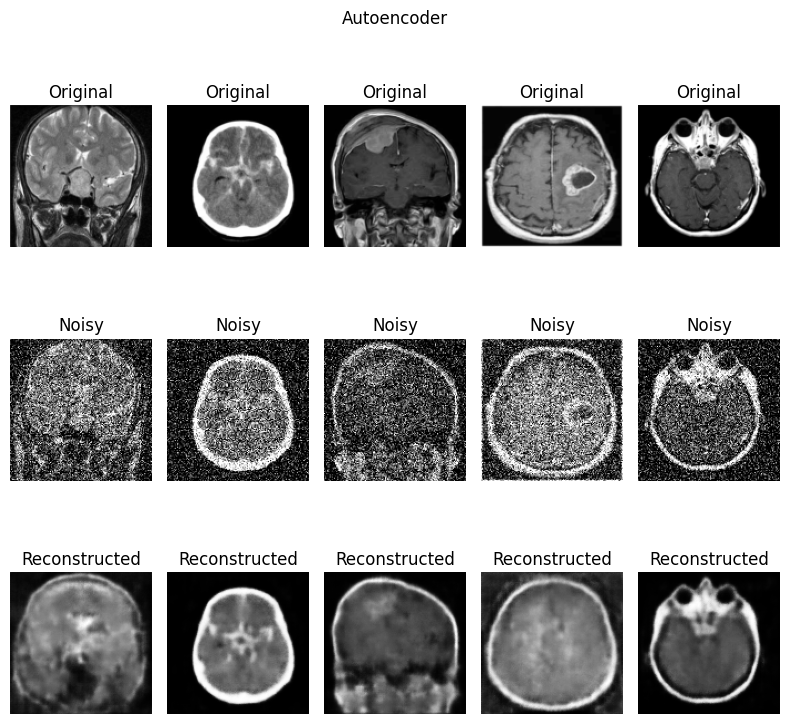

Average_loss,█▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Average_loss,0.00385
epoch,40


In [10]:
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
train_AE()